In [1]:
import sys
sys.path.append('../input/hubmap-2022-env/env_v3/env_v3/')
sys.path.append('../input/hubmap-2022-code/main_folder/main_folder/')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import cv2
import gc
import torchvision
import ttach as tta
import albumentations as A

from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import chain
from os.path import join as pjoin
from copy import deepcopy
from albumentations.pytorch import ToTensorV2

from code_base.models import SMPWrapper, TransformerWrapper
from code_base.datasets import HubMapDataset
from code_base.utils.mask import rle_decode, overlay_mask
from code_base.utils.other import imread_rgb
from code_base.inference import apply_avarage_weights_on_swa_path, HubMapInference
from code_base.constants import CLASSES, PIXEL_SCALE
from code_base.utils.metrics import dice_coeff
from code_base.models import SegmentationTTAWrapperKwargs

monai package was not imported
Custom SMP modifications were not imported. Newer version of SMP
Custom SMP modifications were not imported. Newer version of SMP
torchstain was not imported
albumentations.augmentations.bbox_utils was not imported
torchstain was not imported


# Config

In [3]:
sample_submission = pd.read_csv("../input/hubmap-organ-segmentation/sample_submission.csv")
sample_submission

,id,rle
0,10078,12 34


In [4]:
MODEL_DATASET = "hubmap-2022-models"
REAL_TEST = sample_submission.shape[0] > 1
ONLY_HUBMAP = False
SELECTED_ORGANS = None
REAL_TEST

False

In [5]:
print("Possible exps:\n\n{}".format("\n".join(os.listdir(f"../input/{MODEL_DATASET}/"))))

Possible exps:

unet_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV3X1
unetpp_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV2X1
unet_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_DiceBCEcentr05cont05over025_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV2X1
unet_pointrandX2loss_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV3FX1
cv_split5.npy
unet_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_DiceBCEcentr05cont05over02

In [6]:
EXP_NAME = "unetpp_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV2X1"
print("Possible checkpoints:\n\n{}".format("\n".join(set([os.path.basename(el) for el in glob(
    f"../input/{MODEL_DATASET}/{EXP_NAME}/{EXP_NAME}/*/checkpoints/*.pt*"
) if "train" not in os.path.basename(el)]))))

Possible checkpoints:

swa_models_valid_dice_score.pt


In [7]:
SLIDING_CONFIG = {
    "roi_size": (1024, 1024),
    "sw_batch_size": 4,
    "overlap": 0.75,
    "padding_mode": "reflect"
}

CONFIG = {
    # Main
    "sliding_window_config":
    (
        # Unet++ models
        [None] * 5 +
        # mitb3 models
        [deepcopy(SLIDING_CONFIG) for _ in range(5)] + 
        # Unet models
        [None] * 5 + 
        # Unet models
        [None] * 5
    ),
    "fill_binary_holes": True,
    "test_tresh": 0.5,
#     {
#         'Hubmap': {
#             'kidney'        : 0.6,
#             'prostate'      : 0.5,
#             'largeintestine': 0.5,
#             'spleen'        : 0.6,
#             'lung'          : 0.4,
#         },
#         'HPA': {
#             'kidney'        : 0.5,
#             'prostate'      : 0.4,
#             'largeintestine': 0.4,
#             'spleen'        : 0.5,
#             'lung'          : 0.4,
#         },
#     },
    "use_amp": True,
    # Class names refers to CLASSES.index
    "min_area": [
        0.001, 0.0005, 0.0001, 
        0.001, 1e-06
    ],
    "is_relative_min_area": True,
#     "mean_type": "gmean",
    # Data config
    "n_folds":5,
    "train_data_root":"/home/vova/data/exps/hubmap_2022/train_images/",
    "batch_size": 1,
    "num_workers": 0,
    "pad_config": dict(
        min_height=None, 
        min_width=None, 
        pad_height_divisor=32, 
        pad_width_divisor=32, 
    ),
    "use_one_channel_mask": True,
    "to_rgb": True,
    "additional_scalers": {
        'prostate': 0.15 * 2,
        'spleen': 1 * 2,
        'lung': 0.5 * 2,
        'kidney': 1 * 2,
        'largeintestine': 1 * 2
    },
    # Model config
    "exp_name":EXP_NAME,
    "model_class": SMPWrapper,
    "model_config": { 
#         "backbone_name": "timm-efficientnet-b5",
        "backbone_name": "timm-efficientnet-b7",
#         "num_classes": len(CLASSES),
        "num_classes": 1,
#         "arch_name": "Unet",
        "arch_name": "UnetPP",
#         "arch_name": "UnetGC",
#         "arch_name": "FPN",
        "pretrained":False,
#         "use_slice_idx": True,
#         "aux_params": {"classes": len(CLASSES)},
#         "return_only_mask": True
        
    },
    "tta_transforms": tta.aliases.flip_transform(), #tta.Compose(
#         [
#             tta.HorizontalFlip(),
#             tta.VerticalFlip()
#         ]
#     ),
    "chkp_name":"swa_models_valid_dice_score.pt",
    "swa_checkpoint": None,
    "distributed_chkp": True,
    "use_sigmoid": True,
#     "instance_norm_mode": True
}

In [8]:
# solo tresh 
if isinstance(CONFIG["test_tresh"], float):
    humbap_tresh = CONFIG["test_tresh"]
    hpa_tresh = CONFIG["test_tresh"]
# multi tresh
elif isinstance(CONFIG["test_tresh"], dict):
    humbap_tresh = [CONFIG["test_tresh"]["Hubmap"][cls_name] for cls_name in CLASSES]
    hpa_tresh = [CONFIG["test_tresh"]["HPA"][cls_name] for cls_name in CLASSES]

In [9]:
ADITIONAL_MODELS = [
    {
        "exp_name":"unet_mitb5_strongaugs_1024_lr1e4_BceDiceFocalIoU_bs12_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV4X16_denisx2scales_datav2_HpaPseudoV3FX1",
        "model_config": {
            "backbone_name": "mit_b5",
            "num_classes": 1, 
            "arch_name": "Unet",
            "pretrained":False,
        },
        "distributed_chkp": True,
        "chkp_name":"swa_models_valid_dice_score.pt",
        "tta_transforms": tta.aliases.flip_transform()
    },
    {
        "exp_name":"deeplabv3p_pointrandX2loss_timmefficientnetb5NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV2X1",
        "model_config": {
            "backbone_name": "timm-efficientnet-b7",
            "num_classes": 1, 
            "arch_name": "Unet",
            "pretrained":False,
            "point_rand_config": {"in_ch": 161, "num_classes": 1, "backbone_type": "effnet"},
        },
        "distributed_chkp": True,
        "chkp_name":"swa_models_valid_dice_score.pt",
        "tta_transforms": tta.aliases.flip_transform()
    },
#     {
#         "exp_name":"unet_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV2X1",
#         "model_config": {
#             "backbone_name": "timm-efficientnet-b7",
#             "num_classes": 1, 
#             "arch_name": "Unet",
#             "pretrained":False,
#         },
#         "distributed_chkp": True,
#         "chkp_name":"swa_models_valid_dice_score.pt",
#         "tta_transforms": tta.aliases.flip_transform()
#     },
    {
        "exp_name":"unet_pointrandX2loss_timmefficientnetb7NS_strongaugs_512_lr1e3_BceDiceFocalIoU_bs32_testscale_HMGTEXAndOldTrainP1_datax8_1ch_masksamplingP05_ConcatDataset_DenisPseudoScaledV3X16_denisx2scales_datav2_HpaPseudoV3FX1",
        "model_config": {
            "backbone_name": "timm-efficientnet-b7",
            "num_classes": 1, 
            "arch_name": "Unet",
            "pretrained":False,
            "point_rand_config": {"in_ch": 161, "num_classes": 1, "backbone_type": "effnet"},
        },
        "distributed_chkp": True,
        "chkp_name":"swa_models_valid_dice_score.pt",
        "tta_transforms": tta.aliases.flip_transform()
    },
]

# ADITIONAL_MODELS = None

# Data

In [10]:
test_df = pd.read_csv("../input/hubmap-organ-segmentation/test.csv")
train_df = pd.read_csv("../input/hubmap-organ-segmentation/train.csv").drop(columns=["rle", "age", "sex"]).iloc[:10]

if REAL_TEST:
    hpa_df = test_df[test_df.data_source == "HPA"].reset_index(drop=True)
    hubmap_df = test_df[test_df.data_source == "Hubmap"].reset_index(drop=True)
else:
    hpa_df = train_df
    hubmap_df = test_df

In [11]:
if SELECTED_ORGANS is not None:
    hpa_df = hpa_df[hpa_df.organ.isin(SELECTED_ORGANS)].reset_index(drop=True)
    hubmap_df = hubmap_df[hubmap_df.organ.isin(SELECTED_ORGANS)].reset_index(drop=True)

In [12]:
hpa_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10044,prostate,HPA,3000,3000,0.4,4
1,10274,prostate,HPA,3000,3000,0.4,4
2,10392,spleen,HPA,3000,3000,0.4,4
3,10488,lung,HPA,3000,3000,0.4,4
4,10610,spleen,HPA,3000,3000,0.4,4
5,10611,kidney,HPA,3000,3000,0.4,4
6,10651,largeintestine,HPA,3000,3000,0.4,4
7,10666,prostate,HPA,3000,3000,0.4,4
8,10703,spleen,HPA,3000,3000,0.4,4
9,10892,largeintestine,HPA,3000,3000,0.4,4


In [13]:
hubmap_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


In [14]:
loader_config = {
    "batch_size": CONFIG["batch_size"],
    "drop_last": False,
    "shuffle": False,
    "num_workers": CONFIG["num_workers"],
}
hpa_dataset_config = {
    "root": (
        # For not REAL_TEST run we are using train HPA images
        "../input/hubmap-organ-segmentation/test_images/" if REAL_TEST else "../input/hubmap-organ-segmentation/train_images/"
    ),
    "img_size": None,
    "test_mode": True,
    "precompute": False,
    "dynamic_resize_mode": "scale_or",
    "use_one_channel_mask": CONFIG["use_one_channel_mask"],
    "additional_scalers": CONFIG.get("additional_scalers", None),
    "to_rgb": CONFIG["to_rgb"],
    "transform": [
        A.PadIfNeeded(
            border_mode=4, 
            value=None, 
            mask_value=None, 
            always_apply=True,
            **CONFIG["pad_config"]
        ),
        A.Normalize(), ToTensorV2(transpose_mask=True)
    ]
}
hubmap_dataset_config = {
    "root": "../input/hubmap-organ-segmentation/test_images/",
    "img_size": None,
    "test_mode": True,
    "precompute": False,
    "dynamic_resize_mode": None,
    "use_one_channel_mask": CONFIG["use_one_channel_mask"],
    "additional_scalers": CONFIG.get("additional_scalers", None),
    "to_rgb": CONFIG["to_rgb"],
    "transform": [
        A.PadIfNeeded(
            border_mode=4, 
            value=None, 
            mask_value=None, 
            always_apply=True,
            **CONFIG["pad_config"]
        ),
        A.Normalize(), ToTensorV2(transpose_mask=True)
    ],
    "apply_torchstain_norm": CONFIG.get("torchstain_hubmap", False)
}
hpa_loader = torch.utils.data.DataLoader(
    HubMapDataset(df=hpa_df, **hpa_dataset_config),
    **loader_config
)
hubmap_loader = torch.utils.data.DataLoader(
    HubMapDataset(df=hubmap_df, **hubmap_dataset_config),
    **loader_config
)

Sampler col is not initialized!
Sampler col is not initialized!


In [15]:
hubmap_loader.dataset.apply_torchstain_norm

False

# Model

In [16]:
def set_dropout_zero(model):
    for name, child in model.named_children():
        if isinstance(child, (torch.nn.Dropout, torch.nn.Dropout2d, torch.nn.Dropout3d)):
            child.p = 0.0
        set_dropout_zero(child)

def create_model_and_upload_chkp(
    model_class,
    model_config,
    model_device,
    model_chkp,
    use_distributed=False,
    swa_checkpoint=None,
    tta_transform=None,
    tta_merge_mode="mean",
    instance_norm_mode=False
):
    if "swa" in model_chkp:
        print("swa by {}".format(os.path.splitext(os.path.basename(model_chkp))[0]))
        t_chkp = apply_avarage_weights_on_swa_path(model_chkp, use_distributed=use_distributed, take_best=swa_checkpoint)
    else:
        print("vanilla model")
        t_chkp = torch.load(model_chkp, map_location="cpu")
        
    t_model = model_class(**model_config, device=model_device)
    t_model.load_state_dict(t_chkp)
    if instance_norm_mode:
        t_model.train()
        set_dropout_zero(t_model)
    else:
        t_model.eval()
    if tta_transform is not None:
        print("Wrapping model in TTA")
        t_model = SegmentationTTAWrapperKwargs(t_model, tta_transform, merge_mode=tta_merge_mode)
    return t_model

In [17]:
model = [create_model_and_upload_chkp(
        model_class=CONFIG["model_class"],
        model_config=CONFIG['model_config'],
        model_device="cuda",
        model_chkp=f"../input/{MODEL_DATASET}/{CONFIG['exp_name']}/{CONFIG['exp_name']}/fold_{m_i}/checkpoints/{CONFIG['chkp_name']}",
        swa_checkpoint=CONFIG['swa_checkpoint'],
        use_distributed=CONFIG['distributed_chkp'],
        tta_transform=CONFIG.get("tta_transforms", None),
        instance_norm_mode=CONFIG.get("instance_norm_mode", False)
) for m_i in range(CONFIG["n_folds"])]

swa by swa_models_valid_dice_score
Itter 23 Score 0.8524483837051305 ; Itter 24 Score 0.8516503843818793 ; Itter 30 Score 0.8465728007724309
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 22 Score 0.8351547595332856 ; Itter 27 Score 0.8323665894173549 ; Itter 29 Score 0.830665046527113
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 27 Score 0.8422030708277555 ; Itter 28 Score 0.8414381811435709 ; Itter 38 Score 0.8394036786153317
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 56 Score 0.8428215667415947 ; Itter 52 Score 0.8426736782292027 ; Itter 63 Score 0.8418595680946952
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 43 Score 0.8404469816137398 ; Itter 33 Score 0.8398454532887021 ; Itter 32 Score 0.839693574

In [18]:
if ADITIONAL_MODELS is not None:
    for add_conf in ADITIONAL_MODELS:
        model += [create_model_and_upload_chkp(
                model_class=CONFIG["model_class"],
                model_config=add_conf['model_config'],
                model_device="cuda",
                model_chkp=f"../input/{MODEL_DATASET}/{add_conf['exp_name']}/{add_conf['exp_name']}/fold_{m_i}/checkpoints/{add_conf['chkp_name']}",
                swa_checkpoint=CONFIG['swa_checkpoint'],
                use_distributed=add_conf['distributed_chkp'],
                tta_transform=add_conf.get("tta_transforms", None),
        ) for m_i in range(CONFIG["n_folds"])]


swa by swa_models_valid_dice_score
Itter 17 Score 0.8519968408796833 ; Itter 16 Score 0.851936647797217 ; Itter 28 Score 0.8515152763960995
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 15 Score 0.8482290265328983 ; Itter 20 Score 0.844854099326699 ; Itter 19 Score 0.8421620756975741
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 19 Score 0.8591622926009401 ; Itter 28 Score 0.8538977724456018 ; Itter 30 Score 0.8538894753385813
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 24 Score 0.8516550092143719 ; Itter 33 Score 0.8515242823950724 ; Itter 27 Score 0.8502537461051535
Using None encoder weights
Additional SMP kwargs :
{}
Wrapping model in TTA
swa by swa_models_valid_dice_score
Itter 28 Score 0.8611234910541403 ; Itter 38 Score 0.8601690457660104 ; Itter 39 Score 0.8601393453

In [19]:
print(f"Total models in Blend = {len(model)}")
gc.collect()

Total models in Blend = 20


57

# Inference

In [20]:
inference_class = HubMapInference(
    device="cuda",
    verbose=True,
    verbose_tqdm=True,
    use_sigmoid=CONFIG["use_sigmoid"],
    use_amp=CONFIG["use_amp"]
)

In [21]:
hubmap_test_pred = inference_class.predict_test_loader(
    nn_models=model,
    test_loader=hubmap_loader,
    tresh=humbap_tresh,
    pad_config=CONFIG["pad_config"],
    min_area=CONFIG.get("min_area", None),
    is_relative_min_area=CONFIG.get("is_relative_min_area", False),
    # For HubMap we do not need to resize something. Just crop padding (to X32)
    # In case of additional_scalers we have to rescale
    use_rescaled=CONFIG.get("additional_scalers", None) is not None,
    scale_back=CONFIG.get("additional_scalers", None) is not None,
    fill_binary_holes=CONFIG["fill_binary_holes"],
    sliding_window_config=CONFIG["sliding_window_config"],
    print_input_shape=True,
    mean_type=CONFIG.get("mean_type", "mean")
)

Using tresh : 0.5
Using min_area : [0.001, 0.0005, 0.0001, 0.001, 1e-06]. relative - True
Using model coefs: None
Using save_mask_path: None
Using mean_type: mean


  0%|          | 0/1 [00:00<?, ?it/s]

Input Image shape = torch.Size([1, 3, 1024, 1024])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 11. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 12. Encoder: EfficientNetEncoder. Decod

100%|██████████| 1/1 [00:23<00:00, 23.45s/it]

Removing masks with area less then : 4092


In [22]:
if not ONLY_HUBMAP:
    hpa_test_pred = inference_class.predict_test_loader(
        nn_models=model,
        test_loader=hpa_loader,
        tresh=hpa_tresh,
        pad_config=CONFIG["pad_config"],
        min_area=CONFIG.get("min_area", None),
        is_relative_min_area=CONFIG.get("is_relative_min_area", False),
        # For HPA we have to crop padding (to X32) in rescaled domain and then scale back to original sizes
        use_rescaled=True,
        scale_back=True,
        fill_binary_holes=CONFIG["fill_binary_holes"],
        sliding_window_config=CONFIG["sliding_window_config"],
        print_input_shape=True,
        mean_type=CONFIG.get("mean_type", "mean")
    )

Using tresh : 0.5
Using min_area : [0.001, 0.0005, 0.0001, 0.001, 1e-06]. relative - True
Using model coefs: None
Using save_mask_path: None
Using mean_type: mean


  0%|          | 0/10 [00:00<?, ?it/s]

Input Image shape = torch.Size([1, 3, 640, 640])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 11. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 12. Encoder: EfficientNetEncoder. Decoder

 10%|█         | 1/10 [00:08<01:13,  8.21s/it]

Input Image shape = torch.Size([1, 3, 640, 640])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 11. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 12. Encoder: EfficientNetEncoder. Decoder

 20%|██        | 2/10 [00:16<01:06,  8.28s/it]

Input Image shape = torch.Size([1, 3, 1216, 1216])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Using sliding window
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 11.

 30%|███       | 3/10 [00:51<02:22, 20.42s/it]

Removing masks with area less then : 9000
Input Image shape = torch.Size([1, 3, 1600, 1600])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Using sliding window
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncod

 40%|████      | 4/10 [02:34<05:17, 52.98s/it]

Removing masks with area less then : 9
Input Image shape = torch.Size([1, 3, 1216, 1216])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Using sliding window
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncoder.

 50%|█████     | 5/10 [03:08<03:51, 46.35s/it]

Removing masks with area less then : 9000
Input Image shape = torch.Size([1, 3, 1216, 1216])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Using sliding window
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncod

 60%|██████    | 6/10 [03:43<02:49, 42.37s/it]

Removing masks with area less then : 9000
Input Image shape = torch.Size([1, 3, 2624, 2624])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Using sliding window
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncod

 70%|███████   | 7/10 [09:55<07:30, 150.11s/it]

Input Image shape = torch.Size([1, 3, 640, 640])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 11. Encoder: EfficientNetEncoder. Decoder: UnetDecoder. 
Model idx : 12. Encoder: EfficientNetEncoder. Decoder

 80%|████████  | 8/10 [10:03<03:29, 104.95s/it]

Removing masks with area less then : 4500
Input Image shape = torch.Size([1, 3, 1216, 1216])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Using sliding window
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncod

 90%|█████████ | 9/10 [10:38<01:23, 83.01s/it] 

Removing masks with area less then : 9000
Input Image shape = torch.Size([1, 3, 2624, 2624])
Model idx : 0. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 1. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 2. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 3. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Model idx : 4. Encoder: EfficientNetEncoder. Decoder: UnetPlusPlusDecoder. 
Using sliding window
Model idx : 5. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 6. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 7. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 8. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Using sliding window
Model idx : 9. Encoder: MixVisionTransformerEncoder. Decoder: UnetDecoder. 
Model idx : 10. Encoder: EfficientNetEncod

100%|██████████| 10/10 [16:50<00:00, 101.07s/it]


# Submit

In [23]:
if ONLY_HUBMAP:
    test_pred = hubmap_test_pred
else:
    test_pred = pd.concat([hubmap_test_pred, hpa_test_pred]).reset_index(drop=True)
test_pred

,id,rle
0,10078,385 168 2408 168 4432 166 6455 166 8478 165 10...
1,10044,976468 28 976539 18 979449 156 982449 156 9854...
2,10274,682817 37 685817 37 688817 37 691817 37 694798...
3,10392,1270661 7 1273661 7 1276653 23 1276732 40 1279...
4,10488,3271701 8 3274698 13 3277696 18 3280695 23 328...
5,10610,595926 9 595947 55 598926 9 598947 55 601922 9...
6,10611,742176 35 745166 55 748166 55 751153 76 754153...
7,10651,1240222 18 1243217 30 1246214 37 1249211 47 12...
8,10666,2731199 38 2734190 56 2737190 56 2740190 56 27...
9,10703,820503 7 823483 51 826361 25 826460 92 829361 ...


In [24]:
sample_submission = sample_submission.drop(columns="rle").merge(test_pred, on="id", how="left")
if ONLY_HUBMAP or SELECTED_ORGANS is not None:
    sample_submission["rle"] = sample_submission["rle"].fillna("")
sample_submission

,id,rle
0,10078,385 168 2408 168 4432 166 6455 166 8478 165 10...


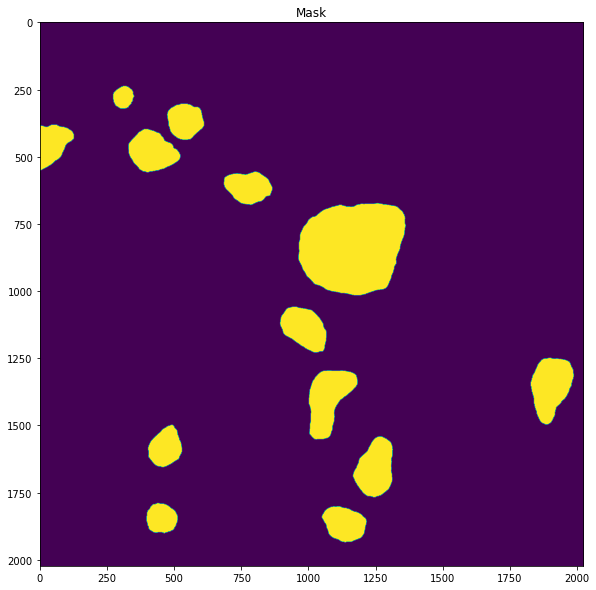

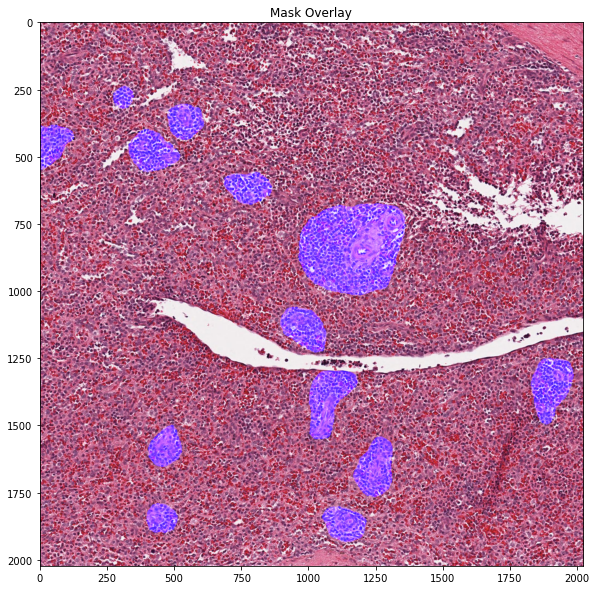

In [25]:
if not REAL_TEST:
    img = imread_rgb(
        f"../input/hubmap-organ-segmentation/test_images/{sample_submission.id.iloc[0]}.tiff"
    )
    mask = rle_decode(sample_submission.rle.iloc[0], shape=(test_df.iloc[0].img_width, test_df.iloc[0].img_height))
    plt.figure(figsize=(10,10))
    plt.title("Mask")
    plt.imshow(mask)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.title("Mask Overlay")
    plt.imshow(overlay_mask(img, mask, color_id=2))
    plt.show()

In [26]:
sample_submission.to_csv("submission.csv", index = False)